# LightGBM

### Установка необходимых зависимостей

In [1]:
# %pip install lightgbm

In [2]:
# %pip install optuna

## Импорты

In [3]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from category_encoders import TargetEncoder
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, make_scorer, f1_score
from scipy import stats
import optuna
from optuna.samplers import TPESampler
import joblib
import warnings
warnings.filterwarnings('ignore')
import gc
import time
from datetime import timedelta

import psutil

### Определение констант

In [4]:
N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 42
TEST_SIZE = 0.2
TRAIN_SIZE = 600000
TIMEOUT = 7200
TARGET_NAME = 'Response'
DATASET_URL = '../data_sources/train.csv' # 'https://media.githubusercontent.com/media/taysumova/urfu_ml/refs/heads/main/data_sources/train.csv'

In [5]:
def time_function(func):
    """Decorator to time function execution"""
    def wrapper(*args, **kwargs):
        start_time = time.time()
        print(f"\n[{time.strftime('%H:%M:%S')}] Starting: {func.__name__}...")
        result = func(*args, **kwargs)
        end_time = time.time()
        elapsed = end_time - start_time
        print(f"[{time.strftime('%H:%M:%S')}] Completed: {func.__name__} in {timedelta(seconds=int(elapsed))}")
        return result
    return wrapper

In [6]:
@time_function
def with_reduce_memory_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print(f"Initial memory usage: {start_mem:.2f} MB")
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                else:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    
    end_mem = df.memory_usage().sum() / 1024**2
    print(f"Memory usage after optimization: {end_mem:.2f} MB")
    print(f"Reduced by {(1 - end_mem/start_mem)*100:.1f}%")
    
    return df

In [7]:
class FrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cols=None):
        self.cols = cols
        self.freq_maps = {}

    def fit(self, X, y=None):
        if self.cols is None:
            self.cols = X.columns
        for col in self.cols:
            self.freq_maps[col] = X[col].value_counts(normalize=True)
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in self.cols:
            X_copy[col] = X_copy[col].map(self.freq_maps[col])
            X_copy[col] = X_copy[col].fillna(self.freq_maps[col].mean())
        return X_copy

    def get_feature_names_out(self, input_features=None):
        if self.cols is None:
            raise ValueError("Колонки не определены. Сначала вызовите fit().")
        return np.array(self.cols)

### Загрузка датасета

In [8]:
# df = with_reduce_memory_usage(
#     pd.read_csv(DATASET_URL)
# )
df = pd.read_csv(DATASET_URL, index_col='id')

print(f"\nDataset shape: {df.shape}")

df.head()


Dataset shape: (11504798, 11)


,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


Удаление последних признаков из feature importance

In [9]:
df = df.drop(['Gender', 'Driving_License', 'Region_Code'], axis=1)

In [10]:
df

,Age,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,
0,21,0,1-2 Year,Yes,65101.0,124.0,187,0
1,43,0,> 2 Years,Yes,58911.0,26.0,288,1
2,25,1,< 1 Year,No,38043.0,152.0,254,0
3,35,0,1-2 Year,Yes,2630.0,156.0,76,0
4,36,1,1-2 Year,No,31951.0,152.0,294,0
...,...,...,...,...,...,...,...,...
11504793,48,0,1-2 Year,Yes,27412.0,26.0,218,0
11504794,26,0,< 1 Year,Yes,29509.0,152.0,115,1
11504795,29,1,< 1 Year,No,2630.0,152.0,189,0


<a id="fource"></a>
### Разделение на признаки и целевую переменную

In [11]:
X = df.drop(TARGET_NAME, axis=1)
y = df[TARGET_NAME]

In [12]:
# Free memory
del df
gc.collect()

10

### Проверка дисбаланса классов

In [13]:
class_start = time.time()
class_counts = y.value_counts()
print(class_counts)
print(f"Imbalance ratio: {class_counts.max() / class_counts.min():.2f}")
class_time = time.time() - class_start

Response
0    10089739
1     1415059
Name: count, dtype: int64
Imbalance ratio: 7.13


### Предобработка признаков

In [14]:
high_card_cols = ['Policy_Sales_Channel']
bool_cols = ['Vehicle_Damage']
ord_cols = ['Vehicle_Age']

preprocessor = ColumnTransformer(
    transformers=[
        ("high_cat", FrequencyEncoder(cols=high_card_cols), high_card_cols),
        ("bool", OneHotEncoder(drop='first', sparse_output=False), bool_cols),
        ("ord", OrdinalEncoder(
            categories=[['< 1 Year', '1-2 Year', '> 2 Years']]
        ), ord_cols),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform='pandas')

transformed_X = preprocessor.fit_transform(X, y)

### Разделение выборок

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    transformed_X, y, train_size=0.2, stratify=y, random_state=42
)
print("Тренировочная выборка:\n", y_train.value_counts(normalize=True), sep="")
print("Тестовая выборка:\n", y_test.value_counts(normalize=True), sep="")

Тренировочная выборка:
Response
0    0.877003
1    0.122997
Name: proportion, dtype: float64
Тестовая выборка:
Response
0    0.877003
1    0.122997
Name: proportion, dtype: float64


### Параметры LightGBM для RandomizedSearchCV

In [16]:
lgb_params = {
    'num_leaves': stats.randint(20, 100),
    'max_depth': stats.randint(3, 15),
    'learning_rate': stats.loguniform(0.001, 0.3),
    'n_estimators': stats.randint(100, 1000),
    'min_child_samples': stats.randint(10, 100),
    'subsample': stats.uniform(0.5, 0.5),
    'colsample_bytree': stats.uniform(0.5, 0.5),
    'reg_alpha': stats.loguniform(1e-8, 10.0),
    'reg_lambda': stats.loguniform(1e-8, 10.0),
    'min_split_gain': stats.uniform(0, 0.1),
}

### Создание LightGBM модели

In [17]:
lgb_model = lgb.LGBMClassifier(
    objective='binary',
    random_state=42,
    n_jobs=-1,
    verbosity=-1,
    is_unbalance=True,
    boosting_type='gbdt'
)

### Использование выборки для RandomizedSearchCV для увеличения скорости

In [18]:
sample_size = min(1000000, len(X_train))
X_sample = X_train
y_sample = y_train
print(f'Размер малой выборки:{sample_size}')

Размер малой выборки:1000000


### RandomizedSearchCV

для дисбаланса

In [19]:
f1_weighted = make_scorer(f1_score, average='weighted')

In [20]:
stratified_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [21]:
random_search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=lgb_params,
    n_iter=10,  # Reduced for speed
    cv=stratified_cv,
    scoring=f1_weighted,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

### Использование RandomizedSearchCV

In [22]:
print("\nStarting RandomizedSearchCV ...")
search_start = time.time()
random_search.fit(X_sample, y_sample)
search_time = time.time() - search_start
print(f"\nRandomizedSearchCV completed in: {timedelta(seconds=int(search_time))}")


Starting RandomizedSearchCV ...
Fitting 3 folds for each of 10 candidates, totalling 30 fits

RandomizedSearchCV completed in: 0:14:21


In [23]:
print("\nЛучшие параметры RandomizedSearchCV:")

for key, value in random_search.best_params_.items():
    print(f"  {key}: {value}")
print(f"Best CV score: {random_search.best_score_:.4f}")


Лучшие параметры RandomizedSearchCV:
  colsample_bytree: 0.8254442364744264
  learning_rate: 0.0013795527822623858
  max_depth: 10
  min_child_samples: 39
  min_split_gain: 0.021233911067827616
  n_estimators: 291
  num_leaves: 79
  reg_alpha: 4.4734294104626844e-07
  reg_lambda: 5.472429642032198e-06
  subsample: 0.762378215816119
Best CV score: 0.8195


### Финальная модель с лучшими параметрами RandomizedSearchCV

In [24]:
train_start = time.time()
print("Тренировка финальной модели с лучшими параметрами RandomizedSearchCV...")
model_rscv = lgb.LGBMClassifier(**random_search.best_params_, 
                                random_state=42,
                                n_jobs=-1,
                                verbosity=-1)
model_rscv.fit(X_train, y_train)
train_time = time.time() - train_start
print(f"Тренировка завершена через: {timedelta(seconds=int(train_time))}")

Тренировка финальной модели с лучшими параметрами RandomizedSearchCV...
Тренировка завершена через: 0:00:23


### Оценка модели c использованием RandomizedSearchCV

In [25]:
eval_start = time.time()
print("\nОценка RandomizedSearchCV модели...")
y_pred_rscv = model_rscv.predict(X_test)
y_pred_proba_rscv = model_rscv.predict_proba(X_test)[:, 1]

print("\nRandomizedSearchCV Model Performance:")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_rscv):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rscv))
eval_time = time.time() - eval_start
print(f"Оценка заняла: {eval_time:.2f} seconds")


Оценка RandomizedSearchCV модели...

RandomizedSearchCV Model Performance:
ROC-AUC: 0.8630

Classification Report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.93   8071792
           1       0.00      0.00      0.00   1132047

    accuracy                           0.88   9203839
   macro avg       0.44      0.50      0.47   9203839
weighted avg       0.77      0.88      0.82   9203839

Оценка заняла: 37.89 seconds


### Сохранение модели

In [26]:
joblib.dump(model_rscv, 'models/lightgbm_random_search_model.pkl')

['models/lightgbm_random_search_model.pkl']

<Axes: >

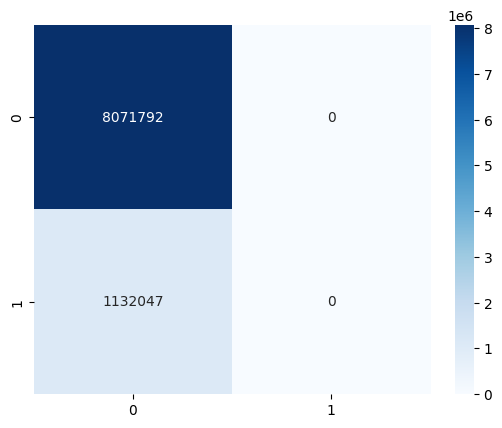

In [27]:
sns.heatmap(confusion_matrix(y_test, y_pred_rscv), annot=True, fmt='d', cmap='Blues')

### Optuna objective function

In [28]:
def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat), True

In [29]:
@time_function
def run_optuna_optimization(n_trials=15):  # Reduced for testing
    def objective(trial):
        trial_start = time.time()
        
        params = {
            'objective': 'binary',
            'boosting_type': 'gbdt',
            'num_leaves': trial.suggest_int('num_leaves', 20, 100),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
            'min_split_gain': trial.suggest_float('min_split_gain', 0, 0.1),
            'random_state': 42,
            'n_jobs': -1,
            'verbosity': -1,
            'is_unbalance': True,
        }
        
        # Use stratified K-fold
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        cv_scores = []
        
        for fold, (train_idx, val_idx) in enumerate(cv.split(X_sample, y_sample)):
            X_train_fold, X_val_fold = X_sample.iloc[train_idx], X_sample.iloc[val_idx]
            y_train_fold, y_val_fold = y_sample.iloc[train_idx], y_sample.iloc[val_idx]
            
            model = lgb.LGBMClassifier(**params)
            model.fit(
                X_train_fold, y_train_fold,
                eval_set=[(X_val_fold, y_val_fold)],
                eval_metric='auc',
                callbacks=[lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(period=1)],
            )
            
            y_pred_proba = model.predict_proba(X_val_fold)[:, 1]
            score = roc_auc_score(y_val_fold, y_pred_proba)
            cv_scores.append(score)
        
        trial_time = time.time() - trial_start
        print(f"  Trial {trial.number} completed in {trial_time:.1f}s with score: {np.mean(cv_scores):.4f}")
        
        return np.mean(cv_scores)
    
    # Create Optuna study
    study = optuna.create_study(
        direction='maximize',
        sampler=TPESampler(seed=42),
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=5)
    )
    
    # Optimize
    print(f"Starting Optuna optimization with {n_trials} trials...")
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    
    return study

### Optuna optimization

In [30]:
optuna_study = run_optuna_optimization(n_trials=15)

print("\nBest parameters from Optuna:")
for key, value in optuna_study.best_params.items():
    print(f"  {key}: {value}")
print(f"Best value: {optuna_study.best_value:.4f}")

[I 2025-12-12 23:16:25,478] A new study created in memory with name: no-name-d56f5a55-4f7b-4309-b476-a0cc70ae6c56



[23:16:25] Starting: run_optuna_optimization...
Starting Optuna optimization with 15 trials...


  0%|          | 0/15 [00:00<?, ?it/s]

[1]	valid_0's auc: 0.852946	valid_0's binary_logloss: 0.347979
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.860454	valid_0's binary_logloss: 0.334965
[3]	valid_0's auc: 0.860051	valid_0's binary_logloss: 0.328033
[4]	valid_0's auc: 0.860457	valid_0's binary_logloss: 0.324093
[5]	valid_0's auc: 0.861655	valid_0's binary_logloss: 0.322116
[6]	valid_0's auc: 0.862309	valid_0's binary_logloss: 0.321581
[7]	valid_0's auc: 0.863137	valid_0's binary_logloss: 0.322073
[8]	valid_0's auc: 0.863882	valid_0's binary_logloss: 0.326358
[9]	valid_0's auc: 0.864571	valid_0's binary_logloss: 0.328679
[10]	valid_0's auc: 0.864769	valid_0's binary_logloss: 0.331162
[11]	valid_0's auc: 0.865009	valid_0's binary_logloss: 0.334515
[12]	valid_0's auc: 0.864949	valid_0's binary_logloss: 0.337953
[13]	valid_0's auc: 0.864978	valid_0's binary_logloss: 0.341663
[14]	valid_0's auc: 0.86566	valid_0's binary_logloss: 0.345174
[15]	valid_0's auc: 0.865496	valid_0's binary_loglos

### Тренировка финальной модели с лучшими параметрами Optuna

In [31]:
train_start = time.time()
print("Training final model with Optuna best parameters...")
best_params = optuna_study.best_params.copy()
best_params.update({
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'random_state': 42,
    'n_jobs': -1,
    'verbosity': -1,
    'is_unbalance': True,
})

model_optuna = lgb.LGBMClassifier(**best_params)
model_optuna.fit(X_train, y_train)
train_time = time.time() - train_start
print(f"Model training completed in: {timedelta(seconds=int(train_time))}")

Training final model with Optuna best parameters...
Model training completed in: 0:00:13


### Оценка модели с Optuna

In [32]:
eval_start = time.time()
print("\nEvaluating Optuna model...")
y_pred_optuna = model_optuna.predict(X_test)
y_pred_proba_optuna = model_optuna.predict_proba(X_test)[:, 1]

print("\nOptuna Model Performance:")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_optuna):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_optuna))
eval_time = time.time() - eval_start
print(f"Evaluation took: {eval_time:.2f} seconds")


Evaluating Optuna model...

Optuna Model Performance:
ROC-AUC: 0.8650

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.81      0.88   8071792
           1       0.35      0.72      0.47   1132047

    accuracy                           0.80   9203839
   macro avg       0.65      0.76      0.67   9203839
weighted avg       0.88      0.80      0.83   9203839

Evaluation took: 22.48 seconds


<Axes: >

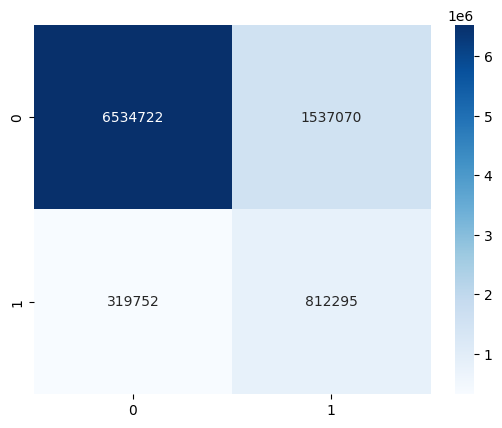

In [33]:
sns.heatmap(confusion_matrix(y_test, y_pred_optuna), annot=True, fmt='d', cmap='Blues')

### Сохранить модель с Optuna

In [34]:
joblib.dump(model_optuna, 'models/lightgbm_optuna_model.pkl')

['models/lightgbm_optuna_model.pkl']

In [35]:
rscv_auc = roc_auc_score(y_test, y_pred_proba_rscv)
optuna_auc = roc_auc_score(y_test, y_pred_proba_optuna)

print(f"RandomizedSearchCV ROC-AUC: {rscv_auc:.4f}")
print(f"Optuna ROC-AUC: {optuna_auc:.4f}")
print(f"\nDifference: {abs(rscv_auc - optuna_auc):.4f}")
print(f"Better model: {'Optuna' if optuna_auc > rscv_auc else 'RandomizedSearchCV'}")

RandomizedSearchCV ROC-AUC: 0.8630
Optuna ROC-AUC: 0.8650

Difference: 0.0020
Better model: Optuna


In [36]:
feat_start = time.time()
print("Calculating feature importance...")
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model_optuna.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

print("\nTop 10 most important features:")
for idx, row in feature_importance.head(10).iterrows():
    print(f"  {row['feature']}: {row['importance']}")

# Save feature importance
feature_importance.to_csv('feature_importance.csv', index=False)
print(f"\nFeature importance saved as 'feature_importance.csv'")
feat_time = time.time() - feat_start
print(f"Feature analysis took: {feat_time:.2f} seconds")

Calculating feature importance...

Top 10 most important features:
  Vintage: 4735
  Age: 3816
  Vehicle_Damage: 2660
  Policy_Sales_Channel: 1337
  Vehicle_Age: 907
  Previously_Insured: 213
  Annual_Premium: 148

Feature importance saved as 'feature_importance.csv'
Feature analysis took: 0.04 seconds
